In [1]:
import gc
import time
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.preprocessing
from datagenerators import DataGeneratorBars
from sklearn.metrics import (
    balanced_accuracy_score,
    confusion_matrix,
    plot_confusion_matrix,
)

In [2]:
import tensorflow
from tensorflow import keras

print("tensorflow", tensorflow.__version__)
print("keras", keras.__version__)

tensorflow 2.3.1
keras 2.4.0


In [3]:
max_neutrons = 4
config = {
    "distance": 15,
    "doubleplane": 30,
    "energy": 600,
    "erel": 500,
    "neutrons": range(1, max_neutrons + 1),
    "subruns": range(6),  # range(19),
    "subrun_cache_size": 6,
    "batch_size": 100,
    "label": "nPN",
    "mode": "barstri",
}

validation_config = config.copy()
validation_config["subruns"] = [19]

In [4]:
start = time.time()
generator = DataGeneratorBars(config)
validation_generator = DataGeneratorBars(validation_config)
print(time.time() - start)

Rows in one file: 10000
400 batches per subrun
2400 total batches in [range(0, 6)] caches
Loading subruns range(0, 6) for cache 0
Rows in one file: 10000
400 batches per subrun
400 total batches in [[19]] caches
Loading subruns [19] for cache 0
228.97507667541504


In [5]:
models = defaultdict(keras.models.Sequential)

models["(SM)"].add(keras.layers.Dense(units=max_neutrons + 1, activation="softmax"))

models["(10, SM)"].add(keras.layers.Dense(units=10, activation="relu"))
models["(10, SM)"].add(keras.layers.Dense(units=max_neutrons + 1, activation="softmax"))

models["(20, SM)"].add(keras.layers.Dense(units=20, activation="relu"))
models["(20, SM)"].add(keras.layers.Dense(units=max_neutrons + 1, activation="softmax"))

models["(100, SM)"].add(keras.layers.Dense(units=100, activation="relu"))
models["(100, SM)"].add(keras.layers.Dense(units=max_neutrons + 1, activation="softmax"))

models["(100, 10, SM)"].add(keras.layers.Dense(units=100, activation="relu"))
models["(100, 10, SM)"].add(keras.layers.Dense(units=10, activation="relu"))
models["(100, 10, SM)"].add(keras.layers.Dense(units=max_neutrons + 1, activation="softmax"))

models["(3000, 50, SM)"].add(keras.layers.Dense(units=3000, activation="relu"))
models["(3000, 50, SM)"].add(keras.layers.Dense(units=50, activation="relu"))
models["(3000, 50, SM)"].add(keras.layers.Dense(units=max_neutrons + 1, activation="softmax"))

optimizer = keras.optimizers.Adam
loss = keras.losses.CategoricalCrossentropy

histories = {}
for name, model in models.items():
    print(name)
    model.compile(loss=loss(), optimizer=optimizer(), metrics=["accuracy"])
    histories[name] = model.fit(generator, verbose=2, epochs=20, shuffle=False, validation_data=validation_generator)
    print("----")

(SM)
Epoch 1/20
2400/2400 - 29s - loss: 1.2245 - accuracy: 0.5043 - val_loss: 1.0545 - val_accuracy: 0.6224
Epoch 2/20
2400/2400 - 15s - loss: 0.9844 - accuracy: 0.6406 - val_loss: 0.9327 - val_accuracy: 0.6538
Epoch 3/20
2400/2400 - 14s - loss: 0.8961 - accuracy: 0.6613 - val_loss: 0.8685 - val_accuracy: 0.6658
Epoch 4/20
2400/2400 - 14s - loss: 0.8433 - accuracy: 0.6707 - val_loss: 0.8263 - val_accuracy: 0.6720
Epoch 5/20
2400/2400 - 14s - loss: 0.8070 - accuracy: 0.6772 - val_loss: 0.7966 - val_accuracy: 0.6765
Epoch 6/20
2400/2400 - 14s - loss: 0.7808 - accuracy: 0.6817 - val_loss: 0.7750 - val_accuracy: 0.6796
Epoch 7/20
2400/2400 - 14s - loss: 0.7613 - accuracy: 0.6853 - val_loss: 0.7588 - val_accuracy: 0.6816
Epoch 8/20
2400/2400 - 14s - loss: 0.7463 - accuracy: 0.6882 - val_loss: 0.7462 - val_accuracy: 0.6841
Epoch 9/20
2400/2400 - 14s - loss: 0.7345 - accuracy: 0.6904 - val_loss: 0.7363 - val_accuracy: 0.6864
Epoch 10/20
2400/2400 - 14s - loss: 0.7248 - accuracy: 0.6923 - val_

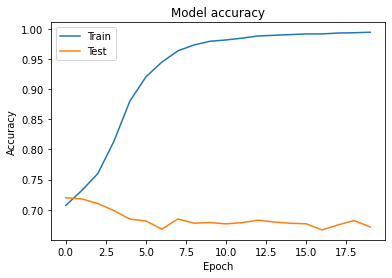

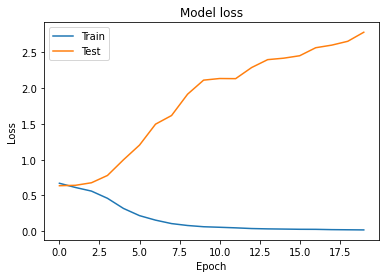

In [6]:
history = histories["(3000, 50, SM)"]

# Plot training & validation accuracy values
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

# Plot training & validation loss values
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

In [7]:
del generator
del validation_generator
gc.collect();

In [8]:
test_config = config.copy()
test_config["subruns"] = range(14, 17)
test_generator = DataGeneratorBars(test_config)

Rows in one file: 10000
400 batches per subrun
1200 total batches in [range(14, 17)] caches
Loading subruns range(14, 17) for cache 0


In [9]:
X = test_generator.features
y_true = np.argmax(test_generator.labels, axis=1)

In [ ]:
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

for name, model in models.items():
    gc.collect()
    y_pred = np.argmax(model.predict(X), axis=1)
    print(name)
    bac = balanced_accuracy_score(y_true, y_pred)
    print(bac)
    cm = confusion_matrix(y_true, y_pred, labels=range(0, len(config["neutrons"]) + 1))
    print(cm)
    cmrel = confusion_matrix(y_true, y_pred, labels=range(0, len(config["neutrons"]) + 1), normalize="true")
    print((cmrel * 100).round())

(SM)
0.7599628579503322
[[ 1544     0     0     0     0]
 [  176 25396  2936    10     6]
 [   26  4829 19246  5795    39]
 [    3   602  5994 14995  8403]
 [    1    56  1095  5848 23000]]
[[100.   0.   0.   0.   0.]
 [  1.  89.  10.   0.   0.]
 [  0.  16.  64.  19.   0.]
 [  0.   2.  20.  50.  28.]
 [  0.   0.   4.  19.  77.]]
(10, SM)
0.7772797521018431
[[ 1544     0     0     0     0]
 [    5 26739  1764     8     8]
 [    1  5240 21098  3540    56]
 [    0   693  7071 15175  7058]
 [    0    76  1373  6402 22149]]
[[100.   0.   0.   0.   0.]
 [  0.  94.   6.   0.   0.]
 [  0.  18.  70.  12.   0.]
 [  0.   2.  24.  51.  24.]
 [  0.   0.   5.  21.  74.]]
(20, SM)
0.774496551346157
[[ 1544     0     0     0     0]
 [    0 26780  1726     8    10]
 [    0  5336 19872  4699    28]
 [    0   697  6275 15779  7246]
 [    0    81  1176  6430 22313]]
[[100.   0.   0.   0.   0.]
 [  0.  94.   6.   0.   0.]
 [  0.  18.  66.  16.   0.]
 [  0.   2.  21.  53.  24.]
 [  0.   0.   4.  21.  74.]]
